#**INF6243** - Techniques d'apprentissage


#**PROJET DE SESSION** : Reconnaissance d'opinions trompeuses sur les sites commerciaux

#Import libraries

In [ ]:
import csv
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import re
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import matplotlib.pyplot as plt
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#Connect to the drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
folder = "/content/drive/MyDrive/INF6243_Hiver2024/Devoirs/"
filename = "amazon_reviews.txt"
!ls $folder

amazon_reviews.txt  default_of_credit_card.xls	glove.twitter.27B.25d.txt


#Data Preparation

In [ ]:
df = pd.read_csv(folder + filename, delimiter='\t')
df.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT
0,1,__label1__,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav..."
1,2,__label1__,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...
2,3,__label1__,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...
3,4,__label1__,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...
4,5,__label1__,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...


#Preprocessing and cleaning

In [ ]:
df["LABEL"].value_counts()

LABEL
__label1__    10500
__label2__    10500
Name: count, dtype: int64

In [ ]:
label_review = {"__label1__":"fake", "__label2__":"real" }
df["LABEL"] = df["LABEL"].replace(label_review)

In [ ]:
df["LABEL"].value_counts()

LABEL
fake    10500
real    10500
Name: count, dtype: int64

Reviews : fake = 1 and Real = 0

In [ ]:
df["REVIEW_TEXT"].head()

0    When least you think so, this product will sav...
1    Lithium batteries are something new introduced...
2    I purchased this swing for my baby. She is 6 m...
3    I was looking for an inexpensive desk calcolat...
4    I only use it twice a week and the results are...
Name: REVIEW_TEXT, dtype: object

In [ ]:
#Create function to remove stopwords and stem the words
#load stopwords
english_stopwords = stopwords.words('english')
#load stemmer
stemmer = SnowballStemmer('english')
#Test stemmer
stemmer.stem("running")
def remove_stopwords_and_stemwords(text):
  words = []
  text_lower = text.lower()
  for word in text_lower.split(" "):
    if word not in english_stopwords:
      stemwords = stemmer.stem(word)
      words.append(stemwords)

  text_processed = " ".join(words).strip()

  return text_processed

In [ ]:
#Apply the remove stopwords and stem function on review text
df["REVIEW_TEXT_P"] = df["REVIEW_TEXT"].apply(remove_stopwords_and_stemwords)
df.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,REVIEW_TEXT_P
0,1,fake,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...","least think so, product save day. keep around ..."
1,2,fake,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,lithium batteri someth new introduc market ave...
2,3,fake,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,purchas swing baby. 6 month pretti much grown ...
3,4,fake,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,look inexpens desk calcolatur is. work everyth...
4,5,fake,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,use twice week result great. use teeth whiten ...


#Split the data train (80 percent) and test (20 percent)

---



In [ ]:
#spliting data using sklearn.model_selection
train_data, test_data = train_test_split(df, test_size=0.2, stratify=df["LABEL"], random_state=32)

In [ ]:
#Define length
len(train_data),len(test_data)

(16800, 4200)

In [ ]:
#Define Global Variable for padding and modelling
NUM_WORDS = 10000
EMBEDDING_DIM = int(np.power(NUM_WORDS,1/4))
MAXLEN = 150
PADDING = 'post'
OOV_TOKEN = "<OOV>"

In [ ]:
print(EMBEDDING_DIM)

10


#Tokenization

In [ ]:
def tokenization(review_text,num_words=NUM_WORDS, oov_token=OOV_TOKEN):
  tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)

  tokenizer.fit_on_texts(review_text)

  return tokenizer

In [ ]:
train_data

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,REVIEW_TEXT_P
20815,20816,real,5,Y,Shoes,B00MMPHMD4,Twisted Women's Trooper Faux Suede Ankle Comba...,A little small,so I normally wear an 8.5 and I ordered a 9. T...,normal wear 8.5 order 9. littl snug leav much ...
17003,17004,real,4,Y,Office Products,B004X23ULW,Sophia Global Compatible Ink Cartridge Replace...,It's worth the money,I am happy with the product. I could not tell ...,happi product. could tell differ canon product...
5322,5323,fake,5,Y,Kitchen,B00PQKB2NI,Brieftons NextGen Spiralizer: 4-Blade Vegetabl...,Yummy zucchini noodles!,It works much better than I expected. I really...,work much better expected. realli thought i'd ...
16917,16918,real,2,Y,Watches,B00HEU282C,Genuine Leather Watch Strap Replacement for Sk...,Photo is wrong color,Warning: The photo is of a brown band. The hea...,warning: photo brown band. headlin top descrip...
11529,11530,real,5,Y,Home Entertainment,B00HZI0Y0Q,VIZIO E241i-B1 24-Inch 1080p 60Hz Smart LED HD...,This is my 3rd exact TV and love them all. Fo...,This is my 3rd exact TV and love them all. Fo...,"3rd exact tv love all. size cost, 1080p smart..."
...,...,...,...,...,...,...,...,...,...,...
5890,5891,fake,5,Y,Office Products,B00PJEY0MG,Colore Liquid Chalk Markers - Best For Restaur...,These are awesome. They are wonderful for writ...,These are awesome. They are wonderful for wr...,awesome. wonder write car windows. daughter...
10762,10763,real,5,N,Books,1612183123,Trail of Dead (Scarlett Bernard),"Great Characters, Excellent Story",Trail of Dead is the second Scarlett Bernard N...,trail dead second scarlett bernard novel. rea...
19062,19063,real,3,Y,Lawn and Garden,B004UCW0PC,"The Dirty Gardener Centipede Grass Seed, 5 Pounds",Too many weed seeds.,There are too many weed seeds in the centipede...,mani weed seed centiped grass seed. pull sever...
19078,19079,real,1,N,Electronics,B007H1ZB5Y,Acoustic Research ARAP50 Wireless Audio System...,"after 45 minutes on this system, I threw it ...","after 45 minutes on this system, I threw it aw...","45 minut system, threw away. piec trash. tri..."


In [ ]:
tokenizer1 = tokenization(df['REVIEW_TEXT_P'])
word_index = tokenizer1.word_index
len(word_index)

32682

In [ ]:
df.head()

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,REVIEW_TEXT_P
0,1,fake,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...","least think so, product save day. keep around ..."
1,2,fake,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,lithium batteri someth new introduc market ave...
2,3,fake,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,purchas swing baby. 6 month pretti much grown ...
3,4,fake,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,look inexpens desk calcolatur is. work everyth...
4,5,fake,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,use twice week result great. use teeth whiten ...


#Padding

In [ ]:
def sequence_and_padding_review(review_text, tokenizer, padding, maxlen):
  sequences = tokenizer.texts_to_sequences(review_text)
  padded_sequences = pad_sequences(sequences, maxlen=maxlen)
  return padded_sequences


In [ ]:
def length_text(text):
  return len(text)

In [ ]:
df['LEN_TEXT'] = df['REVIEW_TEXT_P'].apply(length_text)
df['LEN_TEXT'].max(), df['LEN_TEXT'].min(), df['LEN_TEXT'].std(), df['LEN_TEXT'].mean()

(9689, 39, 303.61009215711044, 227.47085714285714)

In [ ]:
df['REVIEW_TEXT_P'].str.len().max(),df['REVIEW_TEXT_P'].str.len().argmax()

(9689, 17868)

In [ ]:
len(df['REVIEW_TEXT_P'][17868])

9689

In [ ]:
#Re-define num words and maxlen
NUM_WORDS = 33000
MAXLEN = 300
EMBEDDING_DIM = int(np.power(NUM_WORDS,1/4))

In [ ]:
train_padded_sequence = sequence_and_padding_review(train_data['REVIEW_TEXT_P'], tokenizer1, PADDING, MAXLEN)
test_padded_sequence = sequence_and_padding_review(test_data['REVIEW_TEXT_P'], tokenizer1, PADDING, MAXLEN)
train_padded_sequence[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

#Label Encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder
#Encode target labels with value between 0 and n_classes-1.
encoder = LabelEncoder()
#On train label
train_label = encoder.fit_transform(train_data['LABEL'])
train_label

array([1, 1, 0, ..., 1, 1, 0])

In [ ]:
#On test label
test_label = encoder.transform(test_data['LABEL'])
test_label

array([0, 0, 0, ..., 0, 1, 1])

In [ ]:
#Verify the shape
train_label.shape, test_label.shape

((16800,), (4200,))

In [ ]:
#Reshape the output
train_label = train_label.reshape(-1,1)
test_label = test_label.reshape(-1,1)

In [ ]:
#Verify the shape
train_label.shape, test_label.shape

((16800, 1), (4200, 1))

#**Modelling**

#Convolutional Model Conv1D

In [ ]:
#My first Model using Convolution(Conv1D) to extract caracteristics
def my_first_model(num_words, embedding_dim, maxlen):
    filters = 128
    tf.random.set_seed(123)

    model = tf.keras.Sequential([
        # Add an embedding layer to convert input sequences to dense vector
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Conv1D(filters, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:
#Create callbacks to monitore the training
filename_model = "best_model.h5"
callback1 = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=6, restore_best_weights=True)
callback2 = tf.keras.callbacks.ModelCheckpoint(filepath=filename_model,
                                               monitor='val_loss',
                                               save_best_only=True)

In [ ]:
#Create the first model
model1 = my_first_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)
#Train the model with fitting
history = model1.fit(train_padded_sequence, train_label, epochs=30, callbacks=[callback1,callback2], validation_data=(test_padded_sequence, test_label))

Epoch 1/30
525/525 [==============================] - 71s 126ms/step - loss: 0.6866 - accuracy: 0.5323 - val_loss: 0.6576 - val_accuracy: 0.6131
Epoch 2/30


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


525/525 [==============================] - 21s 39ms/step - loss: 0.6401 - accuracy: 0.6326 - val_loss: 0.6304 - val_accuracy: 0.6414
Epoch 3/30
525/525 [==============================] - 10s 19ms/step - loss: 0.5732 - accuracy: 0.7210 - val_loss: 0.6392 - val_accuracy: 0.6350
Epoch 4/30
525/525 [==============================] - 8s 14ms/step - loss: 0.5005 - accuracy: 0.7757 - val_loss: 0.6697 - val_accuracy: 0.6338
Epoch 5/30
525/525 [==============================] - 5s 10ms/step - loss: 0.4279 - accuracy: 0.8260 - val_loss: 0.7603 - val_accuracy: 0.6283
Epoch 6/30
525/525 [==============================] - 6s 11ms/step - loss: 0.3598 - accuracy: 0.8637 - val_loss: 0.8429 - val_accuracy: 0.6176
Epoch 7/30
525/525 [==============================] - 4s 8ms/step - loss: 0.2992 - accuracy: 0.8935 - val_loss: 1.0064 - val_accuracy: 0.6186
Epoch 8/30
525/525 [==============================] - 4s 8ms/step - loss: 0.2382 - accuracy: 0.9189 - val_loss: 1.1266 - val_accuracy: 0.6160


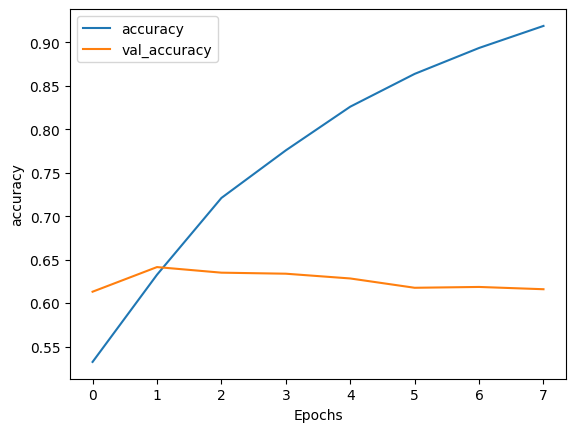

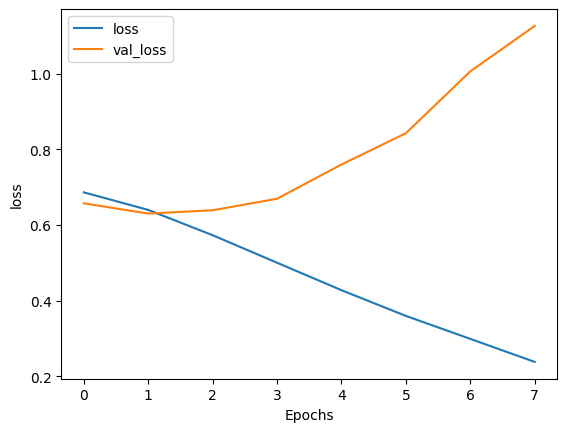

In [ ]:
#Plot metric graph with matplot
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

132/132 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

     real(0)       0.63      0.70      0.66      2100
     fake(1)       0.66      0.58      0.62      2100

    accuracy                           0.64      4200
   macro avg       0.64      0.64      0.64      4200
weighted avg       0.64      0.64      0.64      4200



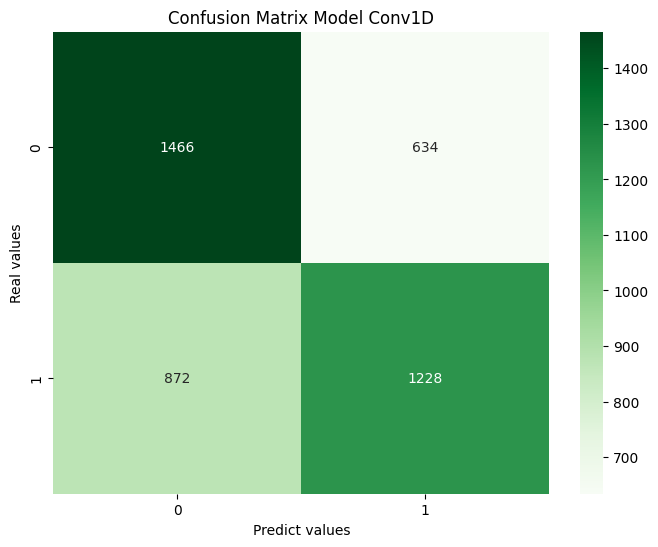

In [ ]:
#Generate classification report
prediction = model1.predict(test_padded_sequence)
class_report_model1 = classification_report(test_label, prediction.round(),target_names=['real(0)','fake(1)'])
print(class_report_model1)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_label, prediction.round()), annot=True, cmap='Greens', fmt='g')
plt.xlabel('Predict values')
plt.ylabel('Real values')
plt.title('Confusion Matrix Model Conv1D')
plt.show()


#Create RNN Model for training (LSTM or GRU)

In [ ]:
#My second Model with RNN, used LSTM or GRU in this case
def my_second_model(num_words, embedding_dim, maxlen):

    tf.random.set_seed(123)

    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=maxlen),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [ ]:
model_gru = my_second_model(NUM_WORDS, EMBEDDING_DIM, MAXLEN)

history = model_gru.fit(train_padded_sequence, train_label, epochs=30, callbacks=[callback1,callback2], validation_data=(test_padded_sequence, test_label))

Epoch 1/30
525/525 [==============================] - 64s 109ms/step - loss: 0.6862 - accuracy: 0.5346 - val_loss: 0.6651 - val_accuracy: 0.5836
Epoch 2/30
525/525 [==============================] - 36s 68ms/step - loss: 0.6241 - accuracy: 0.6563 - val_loss: 0.6377 - val_accuracy: 0.6374
Epoch 3/30
525/525 [==============================] - 31s 58ms/step - loss: 0.5584 - accuracy: 0.7187 - val_loss: 0.6617 - val_accuracy: 0.6295
Epoch 4/30
525/525 [==============================] - 27s 52ms/step - loss: 0.4882 - accuracy: 0.7713 - val_loss: 0.7266 - val_accuracy: 0.6276
Epoch 5/30
525/525 [==============================] - 27s 51ms/step - loss: 0.4229 - accuracy: 0.8155 - val_loss: 0.7758 - val_accuracy: 0.6069
Epoch 6/30
525/525 [==============================] - 27s 52ms/step - loss: 0.3570 - accuracy: 0.8512 - val_loss: 0.9615 - val_accuracy: 0.6138
Epoch 7/30
525/525 [==============================] - 26s 50ms/step - loss: 0.2959 - accuracy: 0.8807 - val_loss: 1.1370 - val_accuracy

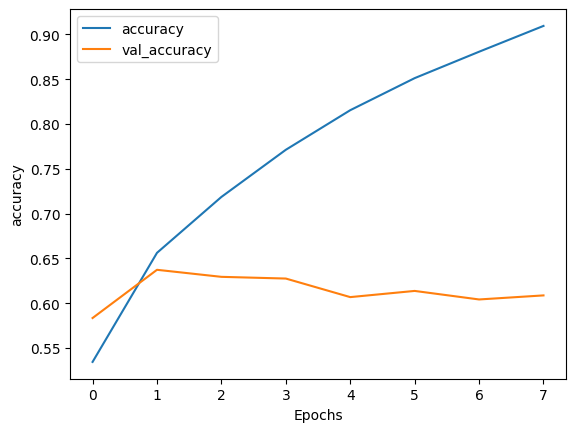

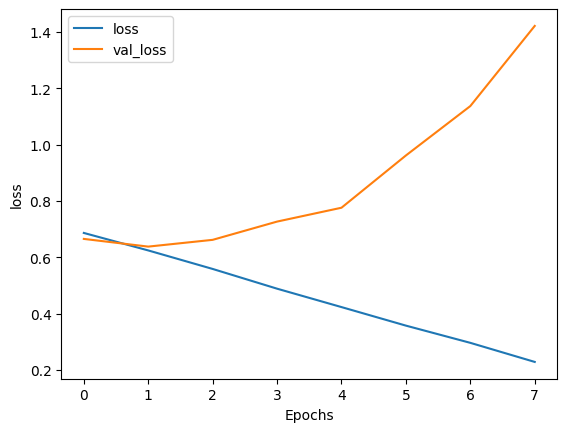

In [ ]:
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

132/132 [==============================] - 2s 19ms/step
              precision    recall  f1-score   support

     real(0)       0.64      0.62      0.63      2100
     fake(1)       0.63      0.66      0.64      2100

    accuracy                           0.64      4200
   macro avg       0.64      0.64      0.64      4200
weighted avg       0.64      0.64      0.64      4200



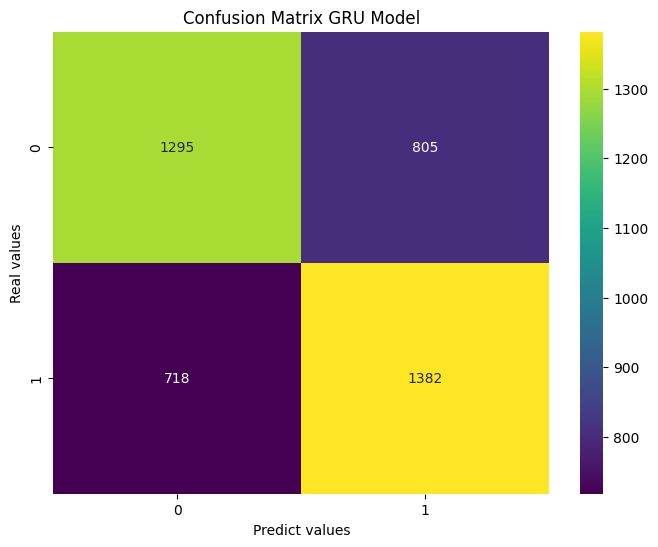

In [ ]:
#Generate classification report
prediction2 = model_gru.predict(test_padded_sequence)
class_report_model_gru = classification_report(test_label, prediction2.round(),target_names=['real(0)','fake(1)'])
print(class_report_model_gru)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_label, prediction2.round()), annot=True, cmap='viridis', fmt='g')
plt.xlabel('Predict values')
plt.ylabel('Real values')
plt.title('Confusion Matrix GRU Model')
plt.show()

#**Transfer learning**

#Twitter Glove embedding preprocessing

In [ ]:
#filename glove embedding (dimension = 25, 27 Billion of word)
filename_glove = folder + 'glove.twitter.27B.25d.txt'

In [ ]:
#Define a dictionary
glove_embedding = {}

with open(filename_glove,'r') as f:
  next(f)
  for line in f:
    values = line.split(" ")
    word = values[0]
    vector = np.asarray(values[1:], dtype="float32")
    glove_embedding[word] = vector


In [ ]:
len(glove_embedding)

1193514

In [ ]:
glove_embedding

In [ ]:
word_index

In [ ]:
word_in = word_index.keys()
word_in

In [ ]:
#Check the number of word present in glove embedding from word index
i = 0
for word in word_in:
  if glove_embedding.get(word) is not None :
    i = i + 1

print(i)

22809


In [ ]:
NUM_WORDS

33000

In [ ]:
embedding_matrix = np.zeros((NUM_WORDS,25))

In [ ]:
embedding_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
embedding_matrix.shape

(33000, 25)

In [ ]:
#Replace all the embedding in the matrix where it was previously initialized with zeros elements (np.zeros)
for word, index in word_index.items():
  if index > NUM_WORDS -1:
     break
  embedding_vector = glove_embedding.get(word)
  if embedding_vector is not None :
      embedding_matrix[index] = embedding_vector

In [ ]:
embedding_matrix

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.54268998, 0.54970998, 0.3725    , ..., 0.32635999, 1.11360002,
        0.13842   ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
len(embedding_matrix)

33000

In [ ]:
#Create Model with GRU
def my_third_model(num_words, maxlen):

    tf.random.set_seed(123)
    embedding_dim = 25
    model = tf.keras.Sequential([
                  tf.keras.layers.Embedding(num_words, embedding_dim, weights=[embedding_matrix],trainable=False),
                  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True, dropout=0.5)),
                  tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64)),
                  tf.keras.layers.Dropout(0.5),
                  tf.keras.layers.Dense(10, activation='relu'),
                  tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [ ]:
#Train the model
model_gru2 = my_third_model(NUM_WORDS,MAXLEN)
history = model_gru2.fit(train_padded_sequence, train_label, epochs=30, validation_data=(test_padded_sequence,test_label), callbacks=[callback1,callback2])

Epoch 1/30
525/525 [==============================] - 29s 46ms/step - loss: 0.6930 - accuracy: 0.5159 - val_loss: 0.6961 - val_accuracy: 0.5293
Epoch 2/30
525/525 [==============================] - 23s 43ms/step - loss: 0.6864 - accuracy: 0.5479 - val_loss: 0.6765 - val_accuracy: 0.5712
Epoch 3/30
525/525 [==============================] - 25s 47ms/step - loss: 0.6776 - accuracy: 0.5756 - val_loss: 0.6715 - val_accuracy: 0.5812
Epoch 4/30
525/525 [==============================] - 24s 46ms/step - loss: 0.6654 - accuracy: 0.5977 - val_loss: 0.6591 - val_accuracy: 0.6057
Epoch 5/30
525/525 [==============================] - 21s 40ms/step - loss: 0.6600 - accuracy: 0.6068 - val_loss: 0.6580 - val_accuracy: 0.6090
Epoch 6/30
525/525 [==============================] - 22s 42ms/step - loss: 0.6553 - accuracy: 0.6095 - val_loss: 0.6597 - val_accuracy: 0.6060
Epoch 7/30
525/525 [==============================] - 22s 42ms/step - loss: 0.6521 - accuracy: 0.6168 - val_loss: 0.6595 - val_accuracy:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


525/525 [==============================] - 22s 42ms/step - loss: 0.6158 - accuracy: 0.6570 - val_loss: 0.6422 - val_accuracy: 0.6302
Epoch 21/30
525/525 [==============================] - 22s 42ms/step - loss: 0.6106 - accuracy: 0.6598 - val_loss: 0.6363 - val_accuracy: 0.6319
Epoch 22/30
525/525 [==============================] - 22s 42ms/step - loss: 0.6099 - accuracy: 0.6625 - val_loss: 0.6381 - val_accuracy: 0.6286


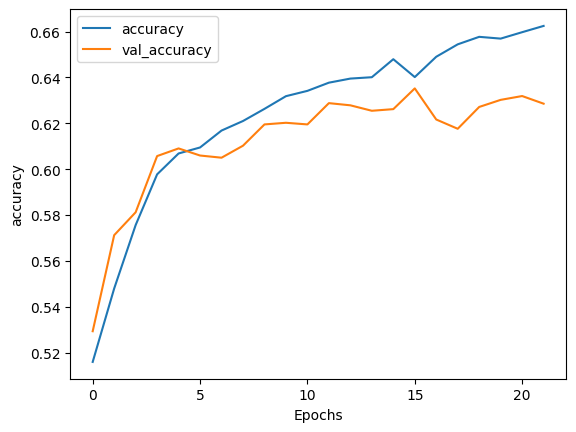

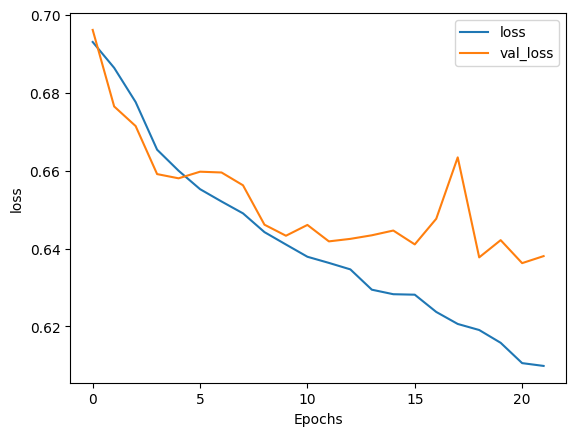

In [ ]:
#Plot the accuracy and loss
#Plot metric graph with matplot
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

132/132 [==============================] - 6s 28ms/step
              precision    recall  f1-score   support

     real(0)       0.65      0.58      0.61      2100
     fake(1)       0.62      0.69      0.65      2100

    accuracy                           0.64      4200
   macro avg       0.64      0.64      0.63      4200
weighted avg       0.64      0.64      0.63      4200



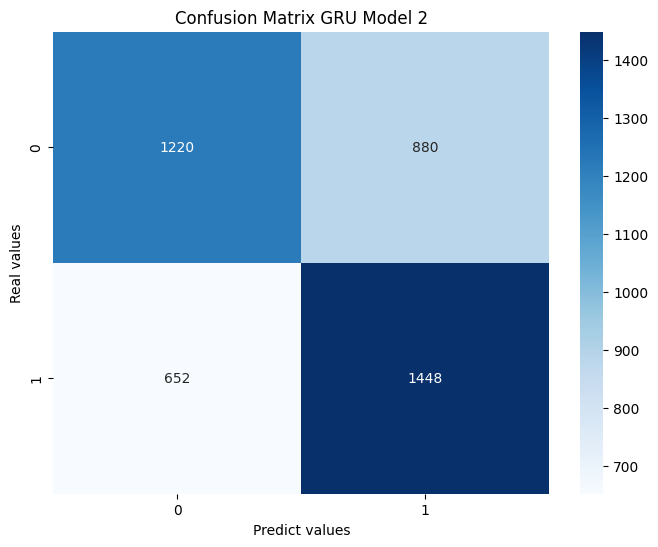

In [ ]:
#Generate classification report
prediction3 = model_gru2.predict(test_padded_sequence)
class_report_model_gru2 = classification_report(test_label, prediction3.round(),target_names=['real(0)','fake(1)'])
print(class_report_model_gru2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(test_label, prediction3.round()), annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predict values')
plt.ylabel('Real values')
plt.title('Confusion Matrix GRU Model 2')
plt.show()